<a href="https://colab.research.google.com/github/nanmaharaj/my-deeplearning-projects/blob/main/bert_spam_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text


import tensorflow_text as text
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df=pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df['Message'],df['spam'],test_size=0.2, stratify=df['spam'])

In [ ]:
y_train.value_counts()

0    3859
1     598
Name: spam, dtype: int64

In [ ]:
bert_preprocess=hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

bert_encoder=hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/3")

In [ ]:
def get_sentence_embedding(sentences):
  preprocessed_text=bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
get_sentence_embedding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132727 , -0.8884572 , ..., -0.7474886 ,
        -0.75314724,  0.91964495],
       [-0.8720834 , -0.50543964, -0.94446665, ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [ ]:
e = get_sentence_embedding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911087]], dtype=float32)

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470381]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

In [ ]:
#creating a functional model(check article)

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

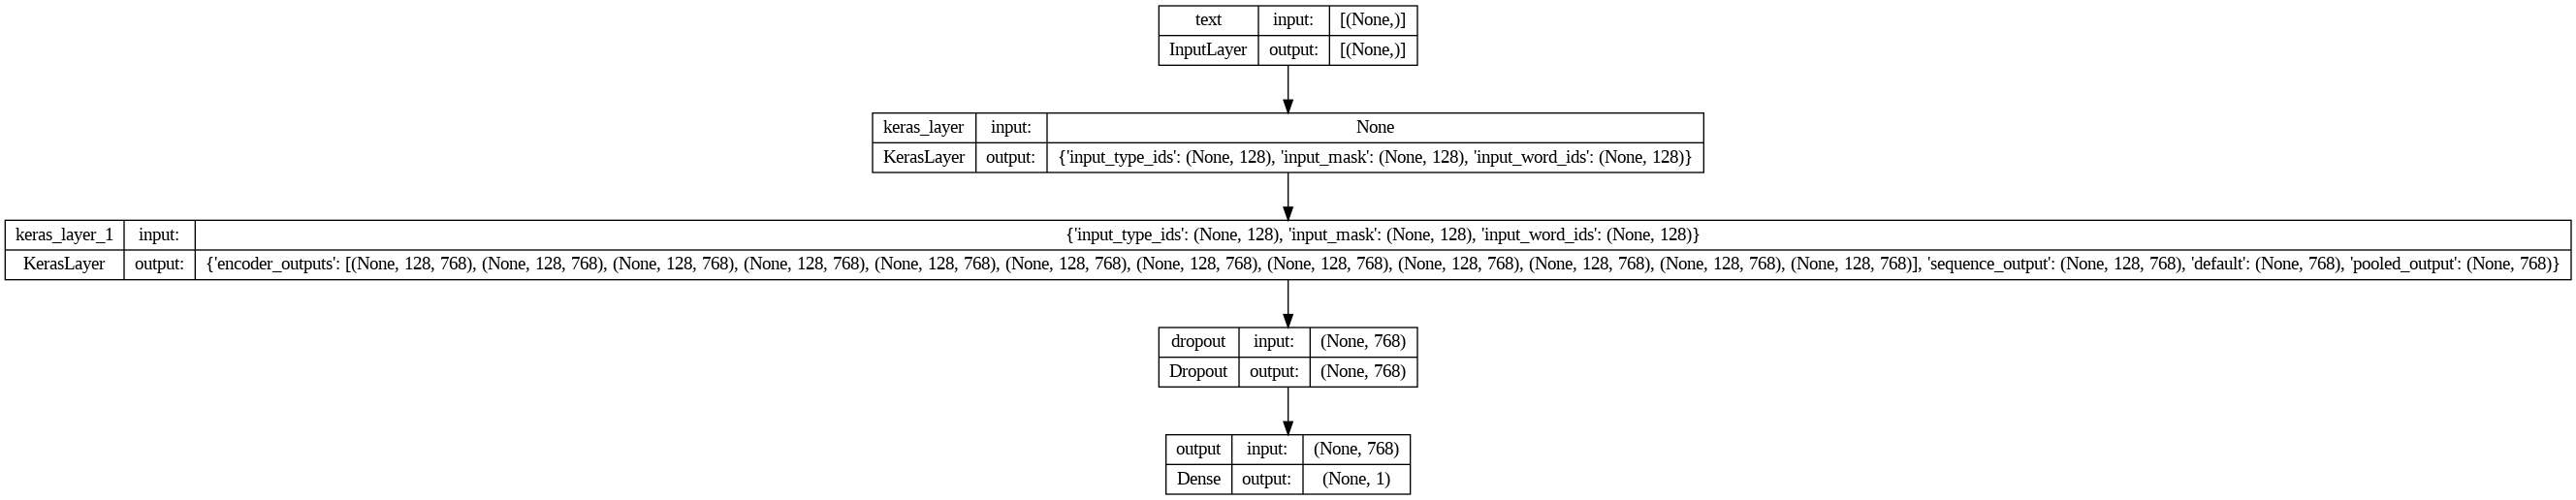

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
140/140 [==============================] - 58s 307ms/step - loss: 0.3690 - accuracy: 0.8452
Epoch 2/5
140/140 [==============================] - 44s 313ms/step - loss: 0.2574 - accuracy: 0.8804
Epoch 3/5
140/140 [==============================] - 45s 324ms/step - loss: 0.2121 - accuracy: 0.9134
Epoch 4/5
140/140 [==============================] - 47s 338ms/step - loss: 0.1858 - accuracy: 0.9280
Epoch 5/5
140/140 [==============================] - 47s 336ms/step - loss: 0.1681 - accuracy: 0.9381


In [ ]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 753ms/step


array([[0.51531655],
       [0.594399  ],
       [0.44613317],
       [0.04342379],
       [0.01767392]], dtype=float32)

In [ ]:
model.save("drive/MyDrive/save_models/1/")

In [ ]:
model.save("drive/MyDrive/save_models/2/")

In [ ]:
model.save("drive/MyDrive/save_models/3/")